# 프로젝트: 한국어 데이터로 챗봇 만들기

- 영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시키기

## 목차
- 1. 프로젝트 개요
- 2. 데이터 수집하기
- 3. 데이터 전처리하기
- 4. Subword TextEncoder 사용하기
    - (1) 단어장(Vacabulary) 만들기
    - (2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
    - (3) 교사 강요(Teacher Forcing) 사용하기
- 5. 모델 구성하기
    - (1) 함수 정의하기
    - (2) 모델 생성하기
    - (3) 손실 함수(Loss Function)
    - (4) 커스텀 된 학습률(Learning rate)
    - (5) 모델 컴파일
    - (6) 훈련하기
- 6. 모델 평가하기

## 1. 프로젝트 개요

### 트랜스포머의 인코더와 디코더
- 트랜스포머 또한 번역기와 마찬가지로 기본적으로 인코더와 디코더 구성 가지고 있음
- 입력 문장을 넣으면 출력 문장을 내뱉고 있음
![트랜스포머.png](./images/트랜스포머.png)
- [출처](http://jalammar.github.io/illustrated-transformer/)
- 위의 블랙박스로 가려져 있는 트랜스포머의 내부 구조를 열어보면 아래와 같음
![트랜스포머2.png](./images/트랜스포머2.png)
- [출처](http://jalammar.github.io/illustrated-transformer/)
- 초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)라고 하였을 때
- 입력 문장은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적해 쌓아올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조 갖고 있음
- 그리고 그 내부를 조금 더 확대해 보면 아래와 같이 톱니바퀴처럼 맞물려 돌아가는 여러 가지 부품들로 구성되어 있음
![트랜스포머3.png](./images/트랜스포머3.png)
- [출처](http://jalammar.github.io/illustrated-transformer/)

### 트랜스포머의 입력 이해하기
![포지셔널인코딩.png](./images/포지셔널인코딩.png)
- 많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정 거침
- 트랜스포머 또한 그 점에서는 다르 모델들과 다르지 않음
- 하지만 트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른 점이 1가지 있음
- 바로 임베팅 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점
- 그 값은 바로 위 그림에서의 '포지셔널 인코딩(positional Encoding)'에 해당하는 부분
- 위 그림에서 인코더의 입력 부분을 조금 더 확대해 본다면 아래 그림과 같을 것
![포지셔널인코딩2.png](./images/포지셔널인코딩2.png)
- 이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문
- 트랜스포머가 RNN과 결정적으로 다른 점이 바로 이 부분
- RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없었음
- 그러나 문장에 있는 모든 단어를 한꺼분에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모름
- 그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는 것
![포지셔널인코딩3.png](./images/포지셔널인코딩3.png)
- 포지셔널 인코딩의 벡터값은 위의 수식에 의해 정해짐
- 사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 행태를 생각해 볼 수 있음
- 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더하여 줌
- 위의 두 함수에서는 pos, i, d model등 생소한 변수들이 있음
- 위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점 이해
![포지셔널인코딩4.png](./images/포지셔널인코딩4.png)
- d model은 임베딩 벡터의 차원을 의미하고 있고, pos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, i는 임베딩 벡터 내의 차원의 인덱스를 의미
- 이렇게 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 되는 것

### 진행에 필요한 패키지 import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print('슝=3')

슝=3


## 2. 데이터 수집하기

- 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터 사용
- 아래의 링크에서 다운로드 받을 수 있음
- [songs/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
- Cloud shell에서 아래 명령어 입력
```python
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/*. ~/aiffel/transformer_chatbot/data/
```

In [2]:
data = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv')
print(data.shape)
data.head()

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 3. 데이터 전처리하기

- 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로 다른 전처리 수행해야 할 수도 있음

- 이를 위한 전처리 함수는 다음과 같음
- 이번 전처리는 **정규 표현식(Regular Expression)**을 사용하여 **구두점(punctuation)**을 제거하여 단어를 **토크나이징(tokenizing)**하는 일에 방해가 되지 않도록 정제하는 것을 목표로 함

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이 거리 만들기
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
print("슝=3")

슝=3


- 데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리

In [4]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    
    for i in range(len(data) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))
  
    return inputs, outputs
print("슝=3")

슝=3


- 로드한 데이터의 샘플 수 확인

In [5]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


- 질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 함
- 둘 다 11,822 개의 샘플이 저장되었음
- 임의로 샘플을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 보기

In [6]:
import random

#랜덤으로 인덱스 뽑아서 5개만 확인할 것.
length = list(range(0,11822,1))
random.shuffle(length)

for i in (length[:5]) :
    print('전처리 후의 {}번째 질문 샘플: {}'.format(i+1, questions[i]))
    print('전처리 후의 {}번째 답변 샘플: {}'.format(i+1, answers[i]))

전처리 후의 8231번째 질문 샘플: 진짜헤어졌네 결국
전처리 후의 8231번째 답변 샘플: 많이 힘들었을 거라 생각해요 .
전처리 후의 10915번째 질문 샘플: 이렇게 또 혼자 좋아하고 이별하고 .
전처리 후의 10915번째 답변 샘플: 짝사랑이 그런가봐요 . 슬프네요 .
전처리 후의 4420번째 질문 샘플: 차 팔아서 불편해
전처리 후의 4420번째 답변 샘플: 불편함을 조금 감수해보세요 .
전처리 후의 8871번째 질문 샘플: 2년 만났어
전처리 후의 8871번째 답변 샘플: 딱 좋을 때네요 .
전처리 후의 2507번째 질문 샘플: 소개받았는데 카톡으로 연락 중
전처리 후의 2507번째 답변 샘플: 썸에서 연인으로 성공하길 바라요 .


## 4. Subword TextEncoder 사용하기

- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 알고 있음
- 하지만, 여기서는 형태소 분석기가 아닌 이 실습에서 사용했던 내부 단어 토크나이저인 'SubwordTextEncoder'를 그대로 사용

- 질문과 답변의 셋을 각각 questions와 answers에 저장하였으므로, 본격적으로 전처리를진행
- 이번 스텝에서 진행할 전체적인 과정을 요약하면 다음과 같음
    - 1. Tensorflow Datasets **SubwordTextEncoder**를 토크나이저로 사용. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 **정수로 인코딩
    - 2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 'START_TOKEN' 및 'END_TOKEN'을 추가
    - 3. 최대 길이 'MAX_LENGTH'인 40을 넘는 문장 필터링
    - 4. MAX_LENGTH보다 길이가 짧ㅇ른 문장들을 40에 맞도록 *패딩*

### (1) 단어장(Vacabulary) 만들기
- 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary) 만들어 보기
- 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듬

In [7]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


- 이때, 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여
- 이미 생성된 번화와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 됨

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


- 시작 토큰과 종료 토큰에 부여된 정수를 출력

In [9]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8161]
END_TOKEN의 번호 : [8162]


- 각각 8161, 8162라는 점에서 현재 단어장의 크기가 8,161(0번부터 8,161번)이라는 의미
- 2개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시

In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8163


### (2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
- 위에서 'tensorflow_datasets'의 'SubwordTextEncoder'를 사용해서 tokenizer를 정의하고 Vacabulary를 만들었음
- 'tokenizer.encode()'로 각 단어를 정수로 변환할 수 있고 또는 'tokenizer.decode()'를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있음
- 예를 들어서 22번째 샘플을 'tokenizer.encode()'의 입력으로 사용해서 변환 결과 보기

In [11]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7501, 7, 6265, 98, 1]


In [12]:
#질문과 답변의 길이 확인
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.937996954829978
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716037895449163


- 각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있음
- 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 **정수 인코딩**을 수행
- 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 **패딩(Padding)**

In [13]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 16
print(MAX_LENGTH)

16


In [14]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
        # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


- 정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외됨
- 단어장의 크기와 샘플의 개수를 확인

In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8163
필터링 후의 질문 샘플 개수: 11675
필터링 후의 답변 샘플 개수: 11675


### (3) 교사 강요(Teacher Forcing) 사용하기
- **tf.data.Dataset API**는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API
- 이를 적극 사용하기 위해서 질문과 답변의 쌍을 'tf.data.Dataset'의 입력으로 넣어주는 작업을 함
- 이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 **교사 강요(Teacher Forcing)**이라는 언어 모델의 훈련 기법 이해해야 함
- 아래의 글을 통해 교사 강요에 대해 알아보기
- [위키독스: RNN 언어 모델](https://wikidocs.net/46496)
- 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 **자기회귀 모델(auto-regressive model, AR)**이라고 함
- 앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예
- 트랜스포머의 디코더 또한 자기회귀 모델
- 트랜스포머 디코더에서도 **교사 강요(Teacher Forcing)**를 적용
- 질문과 답변의 쌍을 **'tf.data.Dataset API**'의 입력으로 사용하여 파이프라인 구축
- 이때, 교사 강요를 위해서 'answers[:, :-1]를 디코더의 입력값, 'answers[:, 1:]를 디코더의 레이블로 사용

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## 5. 모델 구성하기

- 트랜스포머 모델을 구현

### 5.1 함수 정의

In [17]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
            d_model = d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


- 어텐션은 단어들 간의 유사도를 구하는 메커니즘
- 유사도를 구하는 방법이 있을 것
- 트랜스포머에서는 어텐션 값을 구하는 방법으로 아래와 같은 수식을 사용했음
![수식.png](./images/수식.png)
- Q, K, V는 각각 쿼리(Query), 키(Key), 값(Value)를 나타냄
- 앞서 언급했던 어텐션 함수의 정의의 결과값 다시 상기해보기
- 어텐션 함수는 주어진 '쿼리(Query)에 대해서 모든 '키(Key)'와의 **유사도**를 각각 구함
- 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줌
- 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 **어텐션 값(Attention Value)**fkrh gka
- 위 정의와 아래 내용 3가지만 기억하면 수식을 그림으로 정리할 수 있음
    - 1. **Q, K, V**는 단어 벡터를 행으로 하는 문장 행렬
    - 2. 벡터의 **내적(dot product)**은 벡터의 **유사도**를 의미
    - 3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함

- 우선 Q와 K의 전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같음
![행렬.png](./images/행렬.png)
- 문장 행렬 Q와 문장 행렬 K를 곱하면 위의 그림과 같은 초록색 행렬 얻을 수 있음
- 위 초록색 행렬이 의미하는 값은 무엇일까?
- 예를 들어 'am' 행과 'student' 열의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값 의미
- 결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것

- 이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용
- 여기까지가 Q와 K의 유사도를 구하는 과정
- 여기에 문장 행렬 V와 곱하면 **어텐션 값(Attention Value)**를 얻음
![행렬2.png](./images/행렬2.png)
- 결국 이를모두 하나의 그림으로 표현하면 위와 같음
![수식.png](./images/수식.png)
- 이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 **스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)**이라고 함
- 유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙은 것
- 만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 무엇일까?
- 그 어텐션은 당연히 **닷 프로덕트 어텐션(dot product attention)**이라고 부름

In [18]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


### 병렬로 어텐션 수행하기
- 트랜스포머에서 'num_heads'라는 변수는 기계가 몇 개의 똑똑한 머리를 사용할지, 다시 말해 병렬적으로 몇 개의 어텐션 연산을 수행할지 결정하는 하이퍼파라미터
![병렬.png](./images/병렬.png)
- 앞서 포지셔널 인코딩에서 'd_model'은 임베딩 벡터의 차원이라고 언급
- 결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, 'd_model'은 열의 크기로 가짐
- 트랜스포머는 이렇게 입력된 문장 행렬을 'num_heads'의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 'num_heads'의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate함
- 위의 그림은 'num_heads'가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 'd_model'이 됨

### 멀티-헤드 어텐션
- 병렬로 어텐션을 수행하면 얻을 수 있는 효과는 무엇일까?
![멀티헤드어텐션.png](./images/멀티헤드어텐션.png)
- 위 그림은 'num_heads'의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여줌
- 다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 1번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있음
- 예를 들어, 위 그림에서라면 'it_'이라는 토콘이 'animal_'과 유사하다고 보는 관점과 'street_'과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻
- 이와 같이 어텐션을 병렬로 수행하는 것을 **멀티 헤드 어텐션**이라고 부름

### 구현하기
- **멀티 헤드 어텐션**을 구현하면 다음과 같음
- 내부적으로는 **스케일드 닷 프로덕트 어텐션 함수**를 호출

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듬
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


### 패딩 마스킹(Padding Masking)
- 첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법
- 자연어 처리에서 패딩(Padding)이란 어떤 개념일까?
![패딩.png](./images/패딩.png)
- 패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해진 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법
- 위 그림은 케라스의 'pad_sequences()'를 사용하여 패딩을 하는 과정을 시각화한 그림
- 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있음
- **패딩 마스킹**은 이를 위해 숫자 0인 위치를 체크
- 다음은 **패딩 마스킹**을 구현한 함수

In [20]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


- 이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴
- 2개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 확인

In [21]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


- 두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력
- 어텐션 연산 시에 **패딩 마스크**를 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있음

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
- 순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다름
- RNN은 **step**이라는 개념이 존재해서 각 **step**마다 단어가 순서대로 입력으로 들어가는 구조
- 반면, 트래스포머의 경우에는 문장 행렬을 만들어 한번에 행렬 형태로 들어간다는 특증이 있음
- 그리고 이 특징 때문에 추가적인 **마스킹(Masking)**이 필요

#### RNN
- RNN으로 다음 단어를 예측해가면서 문장을 생성해내는 과정 보기
- 다시 말해 RNN으로 **디코더** 구현했을 경우
![RNN.png](./images/RNN.png)
- [출처](http://torch.ch/blog/2016/07/25/nce.html)
- RNN은 구조상으로 다음 단어를 만들어 갈 때, 자신보다 앞에 있는 단어들만 참고해서 다음 단어를 예측
- 위의 그림을 참고로 각 단계에서 다음 단어 예측 과정을 서술하면 다음과 같음
    - **첫 번째 step**
        - 현재까지의 입력: what -> 출력: is
    - **두 번째 step**
        - 현재까지의 입력: what is -> 출력: the
    - **세 번째 step**
        - 현재까지의 입력: what is the -> 출력 problem
        
#### 트랜스포머
- 하지만,트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있음
- 하지만, 우리가 희망하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것
- 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법
- 이 기법은 어텐션을 수행할 때, Query단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 진행
![마스킹.png](./images/마스킹.png)
- 위의 긂에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있음
- 빨간색은 실제 어텐션 연ㅇ산에서가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있음
- 행을 Query, 열을 Key로 표현된 행렬임을 감안하고 천천히 행렬 살펴보기
- 예를 들어 Quer 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 '\<s>, <나는>, <행복을>, <찾고>\'까지의 열만 보이고, 그 뒤 열은 아예 빨간색으로 칠해져 있음
- 즉, 유사도를 구할 수 없도록 해놓음
- 저 빨간색 부분을 마스킹 함수로 구현하면 다음과 같음

In [22]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


### 인코더 층 만들기
![인코더층.png](./images/인코더층.png)
- [출처]( http://jalammar.github.io/illustrated-transformer/)
- 하나의 인코더 층은 크게 2개의 서브 층(sublayer)으로 나눠짐
- 바로 **셀프 어텐션**과 **피드 포워드 신경망**
- 셀프 어텐션은 **멀티 헤드 어텐션**으로 병렬적으로 이루어짐
- 2개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같음
- 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있음

In [23]:
# 인코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 2개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


![인코더층2.png](./images/인코더층2.png)
- [출처](http://jalammar.github.io/illustrated-transformer/)

#### 인코더 층을 쌓아 인코더 만들기
- 이렇게 구현된 인코더 층을 **임베딩 층(Embedding layer)**과 **포지셔널 인코딩(Positional Encoding)**을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됨
- 인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 **Layer Normalization**이라는 테크닉이 사용됨
- 위 그림에서는 **Normalize**라고 표시된 부분에 해당됨
- 트랜스포머는 하이퍼파라미터인 **num_layers** 개수의 인코더 층을 쌓았음
- 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수 사용할 예정

In [24]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 디코더 층
![디코더.png](./images/디코더.png)
- [출처](http://jalammar.github.io/illustrated-transformer/)
- 첫 번재는 **셀프 어텐션**, 두 번째는 **인코더-디코더 어텐션**, 세 번째는 **피드 포워드 신경망**
- **인코더-디코더 어텐션**은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있음
- 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정
![디코더2.png](./images/디코더2.png)
- [출처]( https://medium.com/@shreyasikalra25/predict-movie-reviews-with-bert-88d8b79f5718)
- 인코더의 **셀프 어텐션**과 마찬가지로 디코더의 **셀프 어텐션, 인코더-디코더 어텐션** 2개의 어텐션 모두 **스케일드 닷 프로덕트 어텐션**을 **멀티 헤드 어텐션**으로 병렬적으로 수행
- 디코더의 3개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같음

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 3개의 서브 레이어가 존재
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 디코더 층을 쌓아 디코더 만들기
- 이렇게 구현한 디코더의 층은 **임베딩 층(Embedding layer)**과 **포지셔널 인코딩(Positional Encoding)**을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됨
- 인코더와 마찬가지로 **num_layers** 개수의 디코더 층을 쌓음
- 논문에서는 총 6개의 디코더 총을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정

In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


- 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용해 트랜스포머 함수 정의

In [27]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### (2) 모델 생성하기

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143936     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### (3) 손실 함수(Loss function)
- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용

In [29]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("슝=3")

슝=3


### (4) 커스텀 된 학습률(Learning rate)
- 딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터
- 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있음
- 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 함
- 논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용
- 논문에 나온 공식은 다음과 같음
![공식.png](./images/공식.png)

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


- 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화
- 위에 언급한 수식은 step_num -0.5에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있음
- 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있음

Text(0.5, 0, 'Train Step')

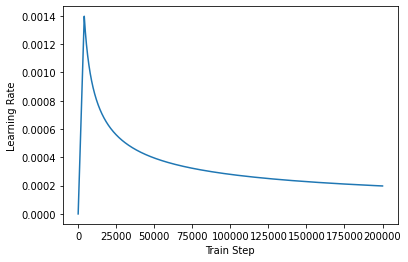

In [31]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### (5) 모델 컴파일
- 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델 컴파일

In [32]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


### (6) 훈련하기
- 총 20 에포크를 학습

In [33]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
183/183 [==============================] - 39s 174ms/step - loss: 3.9073 - accuracy: 0.0319
Epoch 2/20
183/183 [==============================] - 32s 174ms/step - loss: 3.2101 - accuracy: 0.1250
Epoch 3/20
183/183 [==============================] - 32s 174ms/step - loss: 2.6113 - accuracy: 0.1301
Epoch 4/20
183/183 [==============================] - 32s 174ms/step - loss: 2.3993 - accuracy: 0.1386
Epoch 5/20
183/183 [==============================] - 32s 174ms/step - loss: 2.2377 - accuracy: 0.1472
Epoch 6/20
183/183 [==============================] - 32s 174ms/step - loss: 2.0967 - accuracy: 0.1583
Epoch 7/20
183/183 [==============================] - 32s 174ms/step - loss: 1.9114 - accuracy: 0.1729
Epoch 8/20
183/183 [==============================] - 32s 174ms/step - loss: 1.7306 - accuracy: 0.1930
Epoch 9/20
183/183 [==============================] - 32s 174ms/step - loss: 1.5241 - accuracy: 0.2148
Epoch 10/20
183/183 [==============================] - 32s 174ms/step - l

## 6. 모델 평가하기

- 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수 만들기

- 예측(inference) 단계는 기본적으로 다음과 같은 과정을 거침
    - 1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리 거침
    - 2. 입력 문장을 토크나이징하고, 'START_TOKEN'과 'END_TOKEN'ㅇ르 추가
    - 3. 패딩 마스킹과 룩 어헤드 마스킹을 계산
    - 4. 디코더는 입력 시퀀스로부터 다음 단어를 예측
    - 5. 디코더는 예측한 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용
    - 6. 'END_TOKEN'이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춤
- 위의 과정을 모두 담은 'decoder_inference()' 함수 만들기

In [34]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어들은 지속적으로 output_sequence에 추가됨
        # 이 output_sequence는 다시 디코더의 입력이 됨
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


- 임의의 입력 문장에 대해서 'decoder_inference()' 함수를 호출하여 챗봇의 대답을 얻는 'sentence_generation()' 함수 만들기

In [35]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받음
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print("슝=3")

슝=3


- 임의의 문장으로부터 챗봇의 대답 얻어보기

In [38]:
sentence_generation('나 지금 배고파')

입력 : 나 지금 배고파
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

In [39]:
sentence_generation('나 지금 피곤해')

입력 : 나 지금 피곤해
출력 : 좀 더 시간이 필요한 것 같네요 .


'좀 더 시간이 필요한 것 같네요 .'

In [40]:
sentence_generation('오늘 점심 뭐 먹을까?')

입력 : 오늘 점심 뭐 먹을까?
출력 : 맛있는 거 먹고 기분이 나아졌다면 걱정은 넣어두세요 .


'맛있는 거 먹고 기분이 나아졌다면 걱정은 넣어두세요 .'